In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files

files.upload() #this will prompt you to upload the kaggle.json

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"gauravsingh37","key":"aa555d8d832f7e239a366aae66d77d27"}'}

In [ ]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd
!kaggle datasets list

-rw-r--r-- 1 root root 69 Aug 19 01:46 kaggle.json
/content
ref                                                             title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ruchi798/data-science-job-salaries                              Data Science Job Salaries                        7KB  2022-06-15 08:59:12          21164        651  1.0              
josephcheng123456/olympic-historical-dataset-from-olympediaorg  Olympic Historical Dataset From Olympedia.org   25MB  2022-08-18 14:18:14            665         27  1.0              
deepcontractor/mcdonalds-india-menu-nutrition-facts             McDonald's India : Menu Nutrition Dataset        5KB  2022-07-28 17:08:52           1697         90  0.9411765        
gpreda/life-expectancy-in

In [ ]:
!kaggle datasets download -d astraszab/facial-expression-dataset-image-folders-fer2013

 88% 57.0M/65.1M [00:00<00:00, 96.9MB/s]
100% 65.1M/65.1M [00:00<00:00, 94.6MB/s]


In [ ]:
!unzip facial-expression-dataset-image-folders-fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train/6/28451.png  
  inflating: data/train/6/28452.png  
  inflating: data/train/6/28467.png  
  inflating: data/train/6/28471.png  
  inflating: data/train/6/28472.png  
  inflating: data/train/6/28478.png  
  inflating: data/train/6/2848.png   
  inflating: data/train/6/28480.png  
  inflating: data/train/6/28484.png  
  inflating: data/train/6/28485.png  
  inflating: data/train/6/28493.png  
  inflating: data/train/6/28499.png  
  inflating: data/train/6/28507.png  
  inflating: data/train/6/28517.png  
  inflating: data/train/6/28519.png  
  inflating: data/train/6/28520.png  
  inflating: data/train/6/28524.png  
  inflating: data/train/6/28530.png  
  inflating: data/train/6/28531.png  
  inflating: data/train/6/28535.png  
  inflating: data/train/6/28537.png  
  inflating: data/train/6/28539.png  
  inflating: data/train/6/28540.png  
  inflating: data/train/6/28545.png  
  inflating: data/train/6/28546.png  

In [ ]:
import os
import itertools # To join a list of lists
import matplotlib.pyplot as plt # For general plotting
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms


# Utility to visualize PyTorch network and shapes
from torchsummary import summary
np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
random_seed = 7
np.random.seed(random_seed)
torch.manual_seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

Train dataset has N = 28709 samples
Test dataset has N = 3589 samples
Validation dataset has N = 3589 samples

Labels corresponding to randomly drawn images from the training set:
surprise	 happy	 sad  	 surprise	 sad  	 surprise	 angry	 happy	


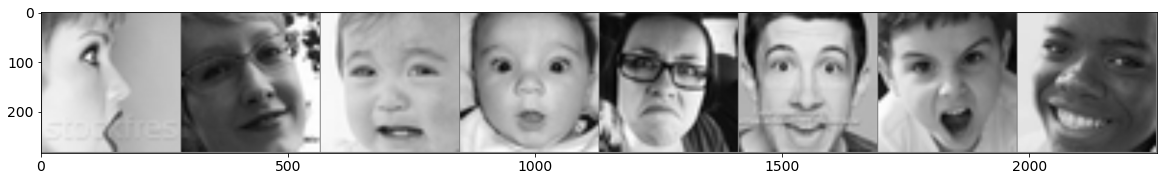

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define how transform the data for processing in batches
transform = transforms.Compose([
        transforms.Resize([280,280]), # Resizing the image
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)) # 0.5 due to how torchvision data is in range [0,1]
    ])
# Specify the batch size for SGD
batch_size = 64

# Use the ImageFolder class, which is a generic dataloder useful when images stored in labelled directories
# Apply transform to images specified above, importantly converting "ToTensor"
train_dataset = torchvision.datasets.ImageFolder(root='data/train', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root='data/test', transform=transform)
valid_dataset = torchvision.datasets.ImageFolder(root='data/val', transform=transform)

classes = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
print("Train dataset has N = {} samples".format(len(train_dataset)))
print("Test dataset has N = {} samples".format(len(test_dataset)))
print("Validation dataset has N = {} samples".format(len(valid_dataset)))

# Define iterable for our newly created dataset and shuffle samples 
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Plotting stuff for visualization ###
fig = plt.figure(figsize=(20,20))
# Utility function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    img_np = img.cpu().numpy()
    plt.imshow(np.transpose(img_np, (1, 2, 0)))


# Get some random training dataset images
dataiter = iter(train_dataloader)
# Extract a batch
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

# Show 8 images for display
num_display = 8
imshow(torchvision.utils.make_grid(images[:num_display]))
# Print labels as a concatenated string
print("\nLabels corresponding to randomly drawn images from the training set:")
print(" ".join(f'{classes[labels[j]]:5s}\t' for j in range(num_display)))

In [ ]:
# Note that PyTorch uses NCHW (samples, channels, height, width) image format convention
class ConvNet(nn.Module):
    def __init__(self, in_channels, num_filters, out_classes, kernel_size=3):
        super().__init__()
        # Conv2D layer with 'same' padding so image retains shape
        self.conv1 = nn.Conv2d(in_channels, num_filters, kernel_size, padding='same')
        # self.conv2_bn = nn.BatchNorm2d(num_filters)
        self.drop = nn.Dropout(p=0.2)
        self.drop2 =nn.Dropout(p=0.2)
        #self.dropout = 
        # MaxPooling layer with 2x2 kernel size and stride 2
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(num_filters, num_filters*2, kernel_size, padding='same')
        self.conv2_bn = nn.BatchNorm2d(num_filters*2)
        self.conv3 = nn.Conv2d(num_filters*2, num_filters*4, kernel_size, padding='same')
        self.conv3_bn = nn.BatchNorm2d(num_filters*4)
        self.conv4 = nn.Conv2d(num_filters*4, num_filters*8, kernel_size, padding='same')
        self.conv4_bn = nn.BatchNorm2d(num_filters*8)
        self.conv5 = nn.Conv2d(num_filters*8, num_filters*16, kernel_size, padding='same')
        self.conv5_bn = nn.BatchNorm2d(num_filters*16)
        self.fc1 = nn.Linear(num_filters*16*8*8, num_filters)
        self.fc1_norm= nn.BatchNorm1d(num_filters)
        self.fc2 = nn.Linear(num_filters, num_filters)
        self.fc2_norm= nn.BatchNorm1d(num_filters)
        self.fc3 = nn.Linear(num_filters, out_classes)


    def forward(self, x):
        # Non-linear ReLU activations between convolutional layers
        # Conv->ReLU->Pooling
        # 280x280 image -> 140x140 after pooling
        x = self.pool(F.relu(self.conv1(x)))
        # print(x.shape)
        # 140x140 feature map -> 70x70 after pooling
        x = self.drop(self.pool(self.conv2_bn(F.relu(self.conv2(x)))))
        # print(x.shape)
        # Flatten all dimensions except batch (start_dim=1)
        x = self.drop(self.pool(self.conv3_bn(F.relu(self.conv3(x)))))
        # print(x.shape)
        x = self.drop(self.pool(self.conv4_bn(F.relu(self.conv4(x)))))
        x = self.drop(self.pool(self.conv5_bn(F.relu(self.conv5(x)))))
        x = torch.flatten(x, 1) 
        # print(x.shape)
        x = self.fc1_norm(F.relu(self.drop2(self.fc1(x))))
        x = self.fc2_norm(F.relu(self.drop2(self.fc2(x))))
        x = self.fc3(x)
        # print("shape is: ", self.conv1.size, self.conv2.size, self.conv3.size, self.fc1.size, self.fc2.size)
        
        return x

input_channels = images.shape[1]
model = ConvNet(input_channels, num_filters=16, out_classes=len(classes))

# Dummy inputs so we can plot a summary of the neural network's architecture and no. of parameters
model=model.to(device)
summary(model, input_size=(input_channels, 280, 280))

# Double check if model exists
# if os.path.exists(os.getcwd() + '/cnn_fmd.pth'):
#     model.load_state_dict(torch.load(os.getcwd() + '/cnn_fmd.pth'))
#     print("Loaded model from disk!")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 280, 280]             448
         MaxPool2d-2         [-1, 16, 140, 140]               0
            Conv2d-3         [-1, 32, 140, 140]           4,640
       BatchNorm2d-4         [-1, 32, 140, 140]              64
         MaxPool2d-5           [-1, 32, 70, 70]               0
           Dropout-6           [-1, 32, 70, 70]               0
            Conv2d-7           [-1, 64, 70, 70]          18,496
       BatchNorm2d-8           [-1, 64, 70, 70]             128
         MaxPool2d-9           [-1, 64, 35, 35]               0
          Dropout-10           [-1, 64, 35, 35]               0
           Conv2d-11          [-1, 128, 35, 35]          73,856
      BatchNorm2d-12          [-1, 128, 35, 35]             256
        MaxPool2d-13          [-1, 128, 17, 17]               0
          Dropout-14          [-1, 128,

In [ ]:
def model_train_loader(model, dataloader, criterion, optimizer):
    size = len(dataloader.dataset)

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        X=X.to(device)
        y=y.to(device)
        predictions = model(X)
        loss = criterion(predictions, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Report loss every 10 batches
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
            
def model_test_loader(model, dataloader, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Tracking test loss (cross-entropy) and correct classification rate (accuracy)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        model.eval()
        for X, y in dataloader:
            X=X.to(device)
            y=y.to(device)
            predictions = model(X)
            test_loss += criterion(predictions, y)
            correct += (predictions.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"\nTest Error\n\tAccuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# The nn.CrossEntropyLoss() loss function automatically performs a log_softmax() to output
criterion = nn.CrossEntropyLoss()
# One is enough for my toy example...
num_epochs = 60
optimizer = torch.optim.Adam(model.parameters(), lr=0.00008)#, momentum=0.9, nesterov=True)

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_train_loader(model, train_dataloader, criterion, optimizer)
    model_test_loader(model, test_dataloader, criterion)
    
# Saving the model file 'cnn_fmd.pth' to my current working directory (cwd)
print("Saving model to disk!")
torch.save(model.state_dict(), os.getcwd() + '/cnn_fmd.pth')

Epoch 1
-------------------------------
loss: 2.177123  [    0/28709]
loss: 2.296377  [  640/28709]
loss: 2.084889  [ 1280/28709]
loss: 1.916442  [ 1920/28709]
loss: 2.148739  [ 2560/28709]
loss: 2.049479  [ 3200/28709]
loss: 2.038434  [ 3840/28709]
loss: 2.070794  [ 4480/28709]
loss: 1.926384  [ 5120/28709]
loss: 2.048480  [ 5760/28709]
loss: 2.075200  [ 6400/28709]
loss: 2.042711  [ 7040/28709]
loss: 2.055386  [ 7680/28709]
loss: 1.927482  [ 8320/28709]
loss: 1.999658  [ 8960/28709]
loss: 2.077408  [ 9600/28709]
loss: 2.004540  [10240/28709]
loss: 2.007305  [10880/28709]
loss: 1.945045  [11520/28709]
loss: 1.869569  [12160/28709]
loss: 1.938420  [12800/28709]
loss: 2.056867  [13440/28709]
loss: 1.944896  [14080/28709]
loss: 1.905140  [14720/28709]
loss: 1.958518  [15360/28709]
loss: 1.858966  [16000/28709]
loss: 1.992688  [16640/28709]
loss: 1.791454  [17280/28709]
loss: 1.922023  [17920/28709]
loss: 2.033635  [18560/28709]
loss: 1.912454  [19200/28709]
loss: 1.852150  [19840/28709]



GroundTruth:
 neutral	 fear 	 sad  	 happy	 happy	 surprise	 happy	 neutral	

Predicted:
 neutral	 surprise	 neutral	 happy	 fear 	 happy	 happy	 happy	


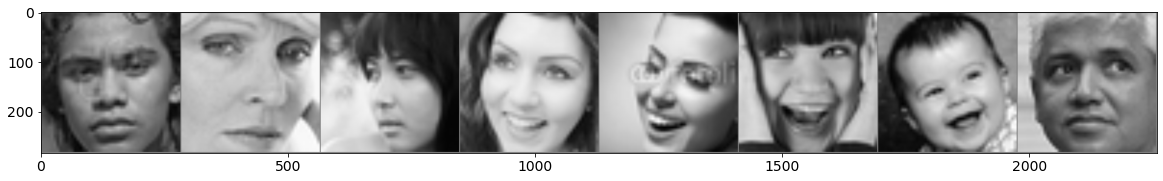

In [ ]:
### Plotting stuff ###
fig = plt.figure(figsize=(20,20))

# Get some random test dataset images
dataiter = iter(test_dataloader)
# Extract a batch
images, labels = dataiter.next()
# Show images
imshow(torchvision.utils.make_grid(images[:num_display]))

outputs = model(images)
# Argmax take the most probable class
_, predicted = torch.max(outputs, 1)

# Print labels
print("\nGroundTruth:\n", " ".join(f'{classes[labels[j]]:5s}\t' for j in range(8)))

print("\nPredicted:\n", " ".join(f'{classes[predicted[j]]:5s}\t' for j in range(8)))

Accuracy of the network on the test set images: 37 %
Confusion Matrix (columns: True class, rows: Predicted class):


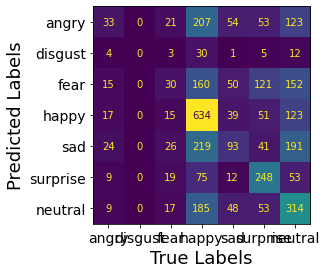

In [ ]:
correct = 0

predicted_list = []
labels_list = []

# Since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    i = 0
    for data in test_dataloader:
        i += 1
        images, labels = data
        # Forward pass through network
        outputs = model(images)
        # Take most probable class
        _, predicted = torch.max(outputs.data, 1)
        predicted_list.append(predicted.detach().numpy())
        labels_list.append(labels.detach().numpy())
        
# Hacky conversions from a list of lists of arrays into joined numpy arrays
predicted_list = np.array(list(itertools.chain.from_iterable(predicted_list)))
labels_list = np.array(list(itertools.chain.from_iterable(labels_list)))
# Count up number of labels and correct predictions
correct = sum(predicted_list == labels_list)

print(f"Accuracy of the network on the test set images: {100 * correct // len(test_dataloader.dataset)} %")

print("Confusion Matrix (columns: True class, rows: Predicted class):")
conf_mat = confusion_matrix(labels_list, predicted_list);
conf_display = ConfusionMatrixDisplay.from_predictions(labels_list, predicted_list, display_labels=classes, colorbar=False);
plt.xlabel("True Labels");
plt.ylabel("Predicted Labels");